# Konwolucyjne sieci neuronowe - cel: obrazki

Dzisiaj poznamy prawdopodobnie najpopularniejszy model sieci neuronowej zaprojektowany do klasyfikacji obrazków wszelkiego rodzaju, a bardziej precyzyjnie: do wszelkich danych, w których istotna jest zależność przestrzenna. Zbudujemy przykładową sieć konwolucyjną (convolutional neural network, CNN), pobawicie się Dropoutem oraz ostatnim sposobem na zwiększanie generalizacji modelu, który poznamy na naszym kursie. Nazywa się on 'data augmentation', polega na generowaniu dodatkowych danych z naszego zestawu danych, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. Będziemy znów pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

## Import danych MNIST

In [ ]:
import numpy as np
import tensorflow as tf
import keras

# Dzisiaj usuniemy przypadkowość z ćwiczenia, żeby mieć pewność, że zobaczymy to, co planuję ;)
seed = 128
rng = np.random.RandomState(seed)

11493376/11490434 [==============================] - 0s 0us/step


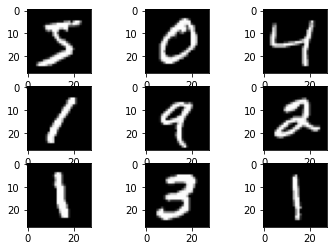

In [ ]:
from keras.datasets import mnist
 
# MNIST współpracuje z keras, zbudowany jest z predefiniowanych 60 000 danych treningowych i 10 000 danych testowych
(X_train, y_train), (X_test, y_test) = mnist.load_data()

from matplotlib import pyplot as plt
# create a grid of 3x3 images
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
 
# show the plot
plt.show()

Dzisiaj korzystamy z sieci konwolucyjnych, które wreszcie zwracają uwagę na przestrzenne zależności w danych, więc możemy do nich wkładać dane o dowolnej wymiarowości. Jedyne co musimy zrobić, to:
- zrobić reshape do następujących wymiarów: [liczba_przykładów][szerokość][wysokość][liczba_kanałów] (czym jest liczba kanałów: czyt. dalej),
- dalej zmieniamy inty na floaty,
- znormalizować jeśli nic więcej z danymi nie robimy, a jeśli stosujemy data augmentation za pomocą gotowych generatorów, to trzeba sprawdzić, czy nie robią tego za nas i być ostrożnym, bo transformacje mogą nam cofnąć normalizację.

Kanały to jedna z głównych magii CNN. Poza tym, że dane mogą być np. 2D, to mogą mieć "warstwy", z których każda ma ten sam wymiar, ale zawiera inne informacje. Może być przydatne w wielu zagadnieniach, ale zaprojektowane to zostało pod kanały RGB, w których każda z trzech warstw obrazka dostarcza informacji o pikselach czerwonych, zielonych i niebieskich. U nas skala jest czarnobiała (greyscale), mamy więc tylko jeden kanał.

In [ ]:
# Reshape'ujemy
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

print(X_train[0].shape)

# Przygotowujemy inty do dzielenia
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Wyjątkowy sposób normalizacji, bo wiemy, że piksele czarno-białe zawierają się w zakresie od 0 do 255
X_train /= 255
X_test /= 255

(28, 28, 1)


In [ ]:
from keras.utils import np_utils

# Musimy jeszcze popracować z etykietkami. Mamy wskazanie, który obrazek przedstawia którą liczbę, ale sieć potrzebuje szczególnego sformatowania
print("Oryginalny sposób zapisu: ", y_train[0])
print(y_train.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print("Po zmianie: ", Y_train[0])
print(Y_train.shape)

Oryginalny sposób zapisu:  5
(60000,)
Po zmianie:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(60000, 10)


## Stworzenie pierwszej architektury sieci konwolucyjnej

Najważniejsza informacja z poprzednich zajęć wciąż działa: **nie ma uniwersalnych i uznanych szczegółowych zasad jak budować optymalną sieć neuronową dla danego problemu**. Głównymi narzędziami programistów są "metoda prób i błędów" oraz stworzona przed doświadczenie intuicja.

Aby jednak stworzyć sieć konwolucyjną, potrzebujemy dwóch dodatkowych typów warstw względem zeszłego tygodnia. Są to warstwy konwolucyjne (Conv1D / Conv2D itp.) oraz warstwy wyciągające (np. MaxPoolingnD, AveragePoolingnD).

### Warstwa konwolucyjna
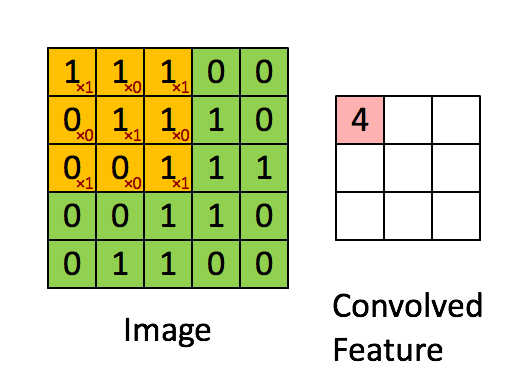

Warstwa konwolucyjna dokonuje konwolucji na (zielonym) obrazku wejściowym i na outpucie zwraca inny (różowy) obrazek. Żółta macierz przesuwająca się po zielonym obrazku (z czerwonymi elementami, które się nie zmieniają) to filtr lub jądro (różna konwencja nazewnictwa). Przesuwa się on po inpucie w sposób ustalony przez hiperparametry takie jak
- size - rozmiar samego filtra, tu: (3,3)
- stride - krok, na gifie = (1,1)
- padding - co zrobić jak filtr ma wyjechać poza obrazek, bo jest niewymiarowy, czyli gdyby w tym przykładzie filtr był 4x4: można ograniczyć ruch tylko do ruchów bez wychodzenia poza ramkę (padding = valid, domyślny), można zrobić ramkę powielającą piksele sąsiadujące (padding = same), można zrobić ramkę z zer.

Ważne! Podczas treningu modelu, parametry fitowane w ramach tej warstwy to parametry filtra! Efektem wytrenowanego modelu są więc dopasowane filtry (+ inne parametry innych warstw).

### Warstwa wyciągająca (pooling)

Jej nadrzędnym celem jest zmniejszenie wymiarów obrazków przy minimalnej utraconej informacji w nich zawartymi między kolejnymi warstwami konwolucyjnymi.

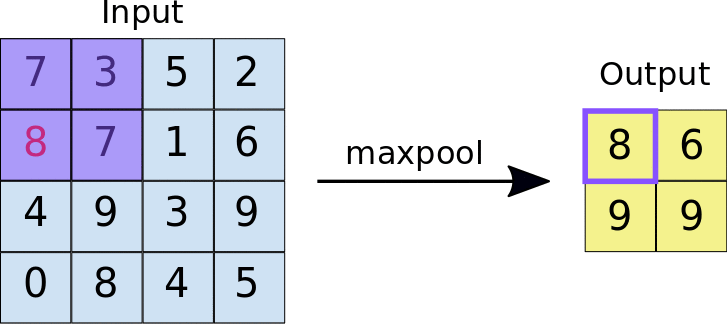

Podobnie jak w warstwie konwolucyjnej, należy ustalić rozmiar filtra (tu: 2x2), stride, padding. Poza MaxPoolem wyciągającym największą liczbę ze skanowanej obecnie przestrzeni, jest też AveragePool wyciągający średnią.

### Przykładowa 2D CNN

In [ ]:
# Importujemy biblioteki do zbudowania sieci
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras import Input

epochs = 10
batch_size = 128

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas

model.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


**PYTANIE:** Czemu po warstwie konwolucyjnej z obrazków (28, 28, 1) dostaliśmy obrazki (26, 26, 32)? 

Odpowiedź może być ogólna jeśli chodzi o wymiar 26x26, ale szczegółowa jeśli chodzi o liczbę 32 ;)

Czemu po MaxPool mamy 13x13x32?

Po co nam Flatten?

**ODPOWIEDŹ:**
1. Filtr o wymiarach 3x3 zmniejsza wymiar filtrowanego obrazu o 2. Postępuje wg wzoru: D_output = D_input - D_filtr + 1
gdzie D oznaczają odpowiednie wymiary. Wymiar 32 bierze się z liczby wyjściowych filtrów zadeklarowanych w funkcji.

2. MaxPool zmniejsza wymiarowość danych o połowę.

3. Flatten służy do spłaszczenia danych, aby dane wejściowe do warstwy Dense miały odpowiedni wymiar.

## Pierwszy trening

Zastosujemy algorytm optymalizacyjny Adam (ze względu na jego dużą szybkość, choć w ogólności ma swoje problemy i warto pamiętać o istnieniu SGD + momentum). Będziemy obserwować dokładność i funkcję błędu modelu zarówno na danych treningowych, jak i testowych.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_noreg = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3)

Epoch 1/10
329/329 [==============================] - 19s 54ms/step - loss: 0.4363 - accuracy: 0.8628 - val_loss: 0.1107 - val_accuracy: 0.9667
Epoch 2/10
329/329 [==============================] - 17s 53ms/step - loss: 0.0814 - accuracy: 0.9771 - val_loss: 0.0731 - val_accuracy: 0.9771
Epoch 3/10
329/329 [==============================] - 18s 54ms/step - loss: 0.0448 - accuracy: 0.9876 - val_loss: 0.0713 - val_accuracy: 0.9782
Epoch 4/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0289 - accuracy: 0.9924 - val_loss: 0.0688 - val_accuracy: 0.9800
Epoch 5/10
329/329 [==============================] - 17s 53ms/step - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0584 - val_accuracy: 0.9833
Epoch 6/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.0578 - val_accuracy: 0.9834
Epoch 7/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.0595 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


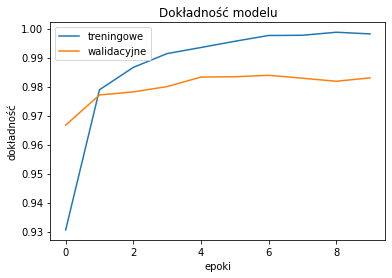

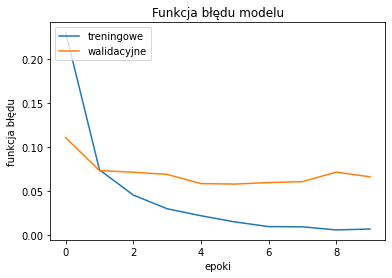

In [ ]:
# Sprawdźmy jakie dane o treningu są zapisane dla naszego treningu 'trained_model_noreg'
print(trained_model_noreg.history.keys())

model_history = trained_model_noreg
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

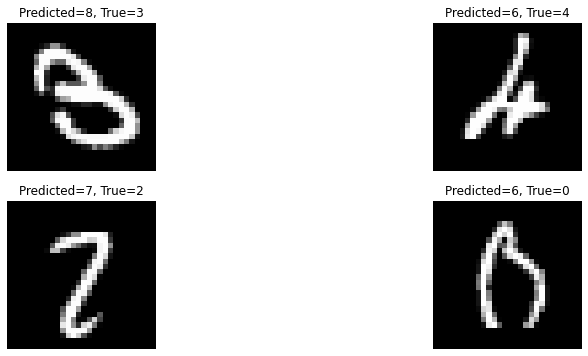

In [ ]:
# Sprawdźmy kilka błędnie sklasyfikowanych obrazków
predict = model.predict(X_test)
y_pred = predict.argmax(axis=-1)

miss_classified = np.nonzero(y_pred != y_test)[0]

for i, incorrect in enumerate(miss_classified[:4]):
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted={}, True={}".format(y_pred[incorrect], y_test[incorrect]))
    plt.axis("off")

In [ ]:
# Raport klasyfikacji
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test, y_pred, labels=[0,1, 2, 3,4,5,6,7,8,9]))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred, normalize=False))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.97      0.99      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 963    0    2    1    1    2    9    1    1    0]
 [   0 1120    2    6    0    0    4    1    2    0]
 [   1    0 1017    3    0    0    2    5    3    1]
 [   0    0    4 1001    0    1    0    1    3    0]
 [   0    0    0    0  970   

## Pierwsze zadanie na dzisiaj: dodaj Dropout

Stwórz model, powtórz kompilację, trening, narysuj krzywe uczenia, spr. źle klasyfikowane obrazki, raport klasyfikacji.

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(10, activation='softmax')) # softmax, bo robimy klasyfikację i mamy 10 klas

model.summary(line_length=None, positions=None, print_fn=None)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_noreg = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3)

Epoch 1/10
329/329 [==============================] - 19s 57ms/step - loss: 0.6032 - accuracy: 0.8116 - val_loss: 0.1496 - val_accuracy: 0.9589
Epoch 2/10
329/329 [==============================] - 18s 53ms/step - loss: 0.1604 - accuracy: 0.9512 - val_loss: 0.1076 - val_accuracy: 0.9692
Epoch 3/10
329/329 [==============================] - 17s 52ms/step - loss: 0.1124 - accuracy: 0.9658 - val_loss: 0.0905 - val_accuracy: 0.9742
Epoch 4/10
329/329 [==============================] - 18s 54ms/step - loss: 0.0952 - accuracy: 0.9721 - val_loss: 0.0839 - val_accuracy: 0.9745
Epoch 5/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0848 - accuracy: 0.9741 - val_loss: 0.0753 - val_accuracy: 0.9779
Epoch 6/10
329/329 [==============================] - 17s 51ms/step - loss: 0.0822 - accuracy: 0.9742 - val_loss: 0.0772 - val_accuracy: 0.9767
Epoch 7/10
329/329 [==============================] - 17s 51ms/step - loss: 0.0688 - accuracy: 0.9786 - val_loss: 0.0785 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


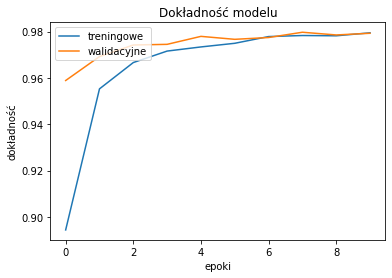

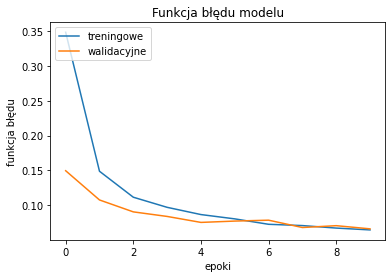

In [ ]:
# Sprawdźmy jakie dane o treningu są zapisane dla naszego treningu 'trained_model_noreg'
print(trained_model_noreg.history.keys())

model_history = trained_model_noreg
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

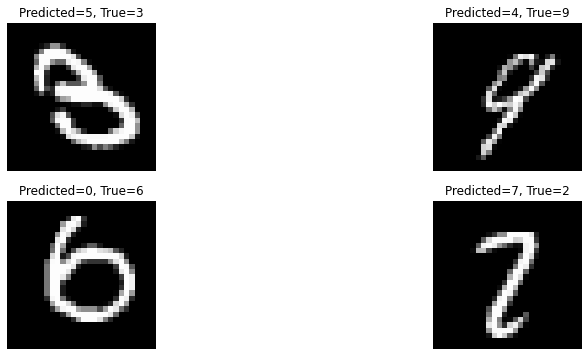

In [ ]:
# Sprawdźmy kilka błędnie sklasyfikowanych obrazków
predict = model.predict(X_test)
y_pred = predict.argmax(axis=-1)

miss_classified = np.nonzero(y_pred != y_test)[0]

for i, incorrect in enumerate(miss_classified[:4]):
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    plt.subplot(2,2,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted={}, True={}".format(y_pred[incorrect], y_test[incorrect]))
    plt.axis("off")

In [ ]:
# Raport klasyfikacji
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test, y_pred, labels=[0,1, 2, 3,4,5,6,7,8,9]))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred, normalize=False))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 970    0    3    0    1    1    3    1    1    0]
 [   0 1132    1    1    0    0    0    0    1    0]
 [   2    8 1005    0    3    0    3    8    3    0]
 [   0    0    5  986    0   10    0    6    2    1]
 [   0    0    0    0  977   

## Data augmentation (generowanie dodatkowych danych)

Data augmentation polega na generowaniu dodatkowych danych z naszego zestawu danych, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. To muszą być transformacje, o których wiemy, że nie powinny wpływać na informacje zawarte w naszych danych. Możemy w ten sposób np. nauczyć maszynę, że obiekty na obrazkach są niezależne od rotacji (przydatne w fizyce!). Można generować dane ręcznie, a można stosować gotowe metody. Dzisiaj zastosujemy metodę Kerasa [ImageDataGenerator](https://keras.io/api/preprocessing/image/), która generuje przetworzone dane na bieżąco. Na [tej](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) stronie macie fajne podsumowanie możliwych transformacji.

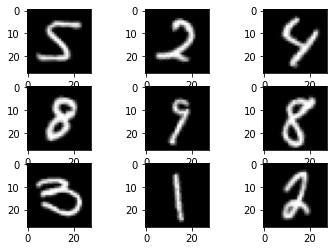

In [ ]:
# Spróbujmy pobawić się lekką rotacją
from keras.preprocessing.image import ImageDataGenerator

# Załadujmy jeszcze raz dane (żeby uniknąć problemu z podwójną normalizacją)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Zmień kształt na [liczba_przykładów][szerokość][wysokość][kanały]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Int -> Float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Wyjątkowy sposób normalizacji, bo wiemy, że piksele czarno-białe zawierają się w zakresie od 0 do 255
#X_train /= 255
#X_test /= 255

# Tu wybieramy rodzaj transormacji. Możemy wiele na raz!
datagen = ImageDataGenerator(rotation_range=30)

# Zastosuj wybrany rodzaj data augmentacji na swoich danych
datagen.fit(X_train)

# Dla celów wizualizacji, jako że ImageDataGenerator generuje przykłady
# 'on-the-fly', aby nie zawalić za dużo pamięci, to zastosujemy metodę 'flow'

for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
  
	plt.show()
	break

Zastosujcie do dalszej części Wasz model z Dropoutem.

In [ ]:
# Nieco bardziej skomplikowane jest dzielenie danych augmentowanych przez ImageDataGenerator na dane treningowe i walidacyjne

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

from sklearn.model_selection import train_test_split

X_training, X_val, Y_training, Y_val = train_test_split(X_train, Y_train, test_size = 0.3)

rotation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = rotation_datagen.flow(X_training, Y_training, batch_size=batch_size) # ustal, że to dane treningowe

validation_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size) # ustal, że to dane walidacyjne

trained_model_rotation = model.fit(train_generator,
    steps_per_epoch = len(X_train) * 0.7 // batch_size,
    validation_data = validation_generator, 
    validation_steps = len(X_train) * 0.3 // batch_size,
    epochs = epochs)


Epoch 1/10
328/328 [==============================] - 24s 73ms/step - loss: 3.4395 - accuracy: 0.8203 - val_loss: 0.4257 - val_accuracy: 0.9542
Epoch 2/10
328/328 [==============================] - 24s 73ms/step - loss: 0.8613 - accuracy: 0.9065 - val_loss: 0.2657 - val_accuracy: 0.9647
Epoch 3/10
328/328 [==============================] - 24s 72ms/step - loss: 0.5868 - accuracy: 0.9241 - val_loss: 0.1991 - val_accuracy: 0.9685
Epoch 4/10
328/328 [==============================] - 24s 73ms/step - loss: 0.4225 - accuracy: 0.9338 - val_loss: 0.1640 - val_accuracy: 0.9722
Epoch 5/10
328/328 [==============================] - 25s 75ms/step - loss: 0.3494 - accuracy: 0.9391 - val_loss: 0.1365 - val_accuracy: 0.9741
Epoch 6/10
328/328 [==============================] - 25s 76ms/step - loss: 0.2874 - accuracy: 0.9437 - val_loss: 0.1216 - val_accuracy: 0.9740
Epoch 7/10
328/328 [==============================] - 26s 81ms/step - loss: 0.2395 - accuracy: 0.9471 - val_loss: 0.1003 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


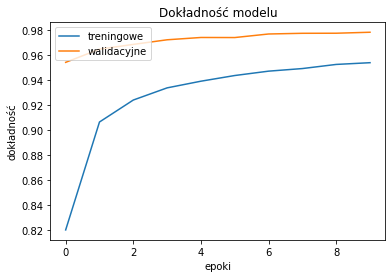

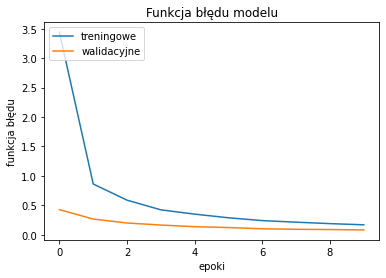

In [ ]:
# Narysujcie krzywe uczenia

print(trained_model_rotation.history.keys())

model_history = trained_model_rotation
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

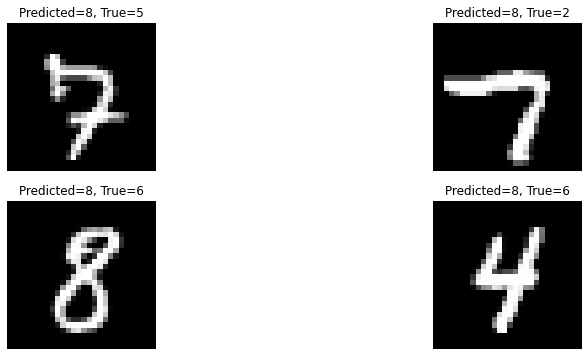

In [ ]:
# Sprawdźcie kilka błędnie sklasyfikowanych obrazków
predict = model.predict(X_val)
y_pred = predict.argmax(axis=-1)

y_classes = tf.math.argmax(Y_val, axis=1)
miss_classified = np.nonzero(y_pred != y_classes)[0]


for i, incorrect in enumerate(miss_classified[:4]):
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    plt.subplot(2,2,i+1)
    plt.imshow(X_training[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted={}, True={}".format(y_pred[incorrect],y_classes[incorrect]))
    plt.axis("off")

In [ ]:
# Raport klasyfikacji
print(classification_report(y_classes, y_pred,labels=[0,1, 2,3,4,5,6,7,8,9])) 
print(confusion_matrix(y_classes, y_pred))
print(accuracy_score(y_classes, y_pred, normalize=False))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1797
           1       0.98      0.96      0.97      2004
           2       0.98      0.77      0.86      1736
           3       0.99      0.62      0.76      1807
           4       0.95      0.97      0.96      1812
           5       1.00      0.31      0.47      1637
           6       0.97      0.95      0.96      1800
           7       0.98      0.93      0.95      1834
           8       0.44      0.99      0.61      1802
           9       0.85      0.96      0.90      1771

    accuracy                           0.84     18000
   macro avg       0.91      0.83      0.84     18000
weighted avg       0.91      0.84      0.84     18000

[[1586    0    5    0    8    0    5    1  170   22]
 [   0 1930    7    0    2    0    0    2   62    1]
 [   0   24 1339    0   13    0    2   15  321   22]
 [   0    8    6 1124    7    0    1    8  590   63]
 [   0    3    0    0 1755   

Co myślicie o tym wyniku? ;)

Wyraźny spadek prawidłowej klasyfikacji cyfr 8 i 9. Cyfra 8 ma dwie osie symetrii, stąd w przypadku rotacji innych cyfr, mogą one przypominać cyfrę 8. Przykład: cyfry 5 i 3.

## Dla chętnych:

Wybierzcie inną transformację z ImageDataGenerator ([tu](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) jest lista części z nich), skomentujcie skąd ten wybór i powtórzcie fitowanie, analizę krzywych uczenia, raport klasyfikacji i wybrane miary jakości na danych testowych.

Wybrałem Random Zoom jako jedną z transformacji z ImageDataGenerator, ponieważ każdy ma inny charakter pisma przez co cyfry są czasami węższe lub szersze.


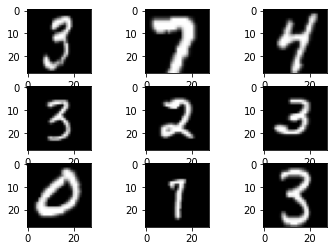

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Załadujmy jeszcze raz dane (żeby uniknąć problemu z podwójną normalizacją)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Zmień kształt na [liczba_przykładów][szerokość][wysokość][kanały]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Int -> Float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

datagen = ImageDataGenerator(zoom_range=0.3)

# Zastosuj wybrany rodzaj data augmentacji na swoich danych
datagen.fit(X_train)

# Dla celów wizualizacji, jako że ImageDataGenerator generuje przykłady
# 'on-the-fly', aby nie zawalić za dużo pamięci, to zastosujemy metodę 'flow'

for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
  
	plt.show()
	break

In [ ]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

from sklearn.model_selection import train_test_split

X_training, X_val, Y_training, Y_val = train_test_split(X_train, Y_train, test_size = 0.3)

rotation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = rotation_datagen.flow(X_training, Y_training, batch_size=batch_size) # ustal, że to dane treningowe

validation_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size) # ustal, że to dane walidacyjne

trained_model_rotation = model.fit(train_generator,
    steps_per_epoch = len(X_train) * 0.7 // batch_size,
    validation_data = validation_generator, 
    validation_steps = len(X_train) * 0.3 // batch_size,
    epochs = epochs)

Epoch 1/10
328/328 [==============================] - 24s 73ms/step - loss: 0.1507 - accuracy: 0.9553 - val_loss: 0.0735 - val_accuracy: 0.9804
Epoch 2/10
328/328 [==============================] - 24s 73ms/step - loss: 0.1448 - accuracy: 0.9575 - val_loss: 0.0715 - val_accuracy: 0.9807
Epoch 3/10
328/328 [==============================] - 24s 73ms/step - loss: 0.1315 - accuracy: 0.9605 - val_loss: 0.0719 - val_accuracy: 0.9801
Epoch 4/10
328/328 [==============================] - 24s 73ms/step - loss: 0.1324 - accuracy: 0.9601 - val_loss: 0.0705 - val_accuracy: 0.9805
Epoch 5/10
328/328 [==============================] - 25s 76ms/step - loss: 0.1269 - accuracy: 0.9607 - val_loss: 0.0676 - val_accuracy: 0.9810
Epoch 6/10
328/328 [==============================] - 24s 74ms/step - loss: 0.1236 - accuracy: 0.9619 - val_loss: 0.0713 - val_accuracy: 0.9800
Epoch 7/10
328/328 [==============================] - 24s 72ms/step - loss: 0.1227 - accuracy: 0.9624 - val_loss: 0.0693 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


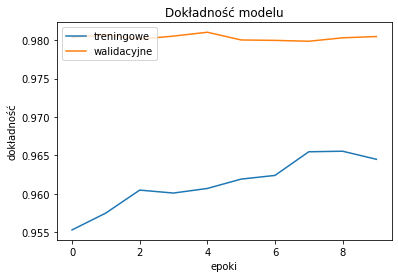

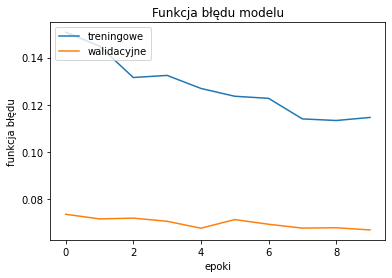

In [ ]:
print(trained_model_rotation.history.keys())

model_history = trained_model_rotation
# Narysujmy wykresy dla dokładności na danych treningowych i testowych
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('dokładność')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

# Narysujmy wykresy dla funkcji błędu na danych treningowych i testowych
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Funkcja błędu modelu')
plt.ylabel('funkcja błędu')
plt.xlabel('epoki')
plt.legend(['treningowe', 'walidacyjne'], loc='upper left')
plt.show()

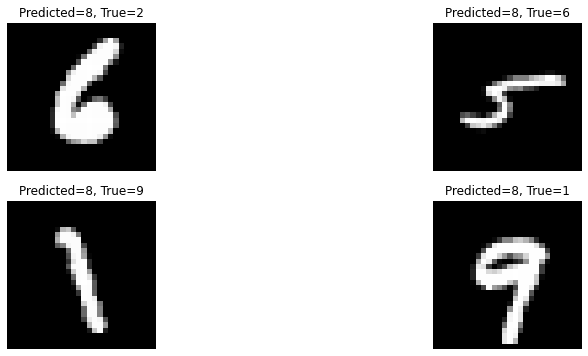

In [ ]:
# Sprawdźcie kilka błędnie sklasyfikowanych obrazków
predict = model.predict(X_val)
y_pred = predict.argmax(axis=-1)

#y_classes = [np.argmax(y, axis=None, out=None) for y in Y_val]
y_classes = tf.math.argmax(Y_val, axis=1)
miss_classified = np.nonzero(y_pred != y_classes)[0]


for i, incorrect in enumerate(miss_classified[:4]):
    fig = plt.gcf()
    fig.set_size_inches(14,6)
    plt.subplot(2,2,i+1)
    plt.imshow(X_training[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted={}, True={}".format(y_pred[incorrect],y_classes[incorrect]))
    plt.axis("off")

In [ ]:
# Raport klasyfikacji
print(classification_report(y_classes, y_pred,labels=[0,1, 2,3,4,5,6,7,8,9])) 
print(confusion_matrix(y_classes, y_pred))
print(accuracy_score(y_classes, y_pred, normalize=False))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64      1784
           1       1.00      0.13      0.23      2000
           2       0.97      0.55      0.70      1753
           3       1.00      0.31      0.47      1812
           4       0.97      0.67      0.80      1795
           5       1.00      0.03      0.06      1627
           6       1.00      0.72      0.83      1736
           7       0.99      0.69      0.81      1912
           8       0.18      1.00      0.31      1803
           9       0.88      0.72      0.80      1778

    accuracy                           0.53     18000
   macro avg       0.90      0.53      0.57     18000
weighted avg       0.90      0.53      0.57     18000

[[ 844    0    2    0    1    0    2    0  935    0]
 [   0  260    4    0    0    0    0    0 1735    1]
 [   0    1  964    0    3    0    0    4  778    3]
 [   0    0    4  564    0    0    0    3 1232    9]
 [   0    0    1    0 1211   

Podobnie jak w przypadku random rotation występuje tu problem z nadreprezentacją cyfry 8. 